In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.linear_model import LinearRegression
import os
import io

In [131]:
# set up graphing defaults to look pretty
sns.set_palette('pastel')
sns.set_theme(rc={'axes.facecolor':'lightgrey'})

# Exploratory Data Analysis
Let's take a deeper look at the data we have. and try to understand and visualize some of the relationships in it.

### Goals:
**Metrics**
- graph distributions of quantitative metrics
    - do this by team
    - do this over time
    - do this by victory?
- find out programmatically which metrics contribute positively to performance and negatively

**Managers**
- convert to datetime
- distribution of term lengths
    - group by team
    
**Both**
- match up manager names to matches
- group by manager
- graph changes of different metrics over time, seeing if there's a jump in the beginning of every manager's term


In [132]:
metrics = pd.read_csv(Path('data') / 'metrics_clean.csv')
metrics.head()

,Date,TotalGoalsScored,FullTimeResult,Team,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,IsHome,Won
0,01/01/17,0,H,Crystal Palace,7,4,NaN,7,4,1,0,False,False
1,01/01/17,4,A,Tottenham,19,6,NaN,6,3,0,0,False,True
2,02/01/17,0,H,Southampton,12,3,NaN,14,8,1,0,False,False
3,02/01/17,1,H,Burnley,11,3,NaN,11,8,3,0,False,False
4,02/01/17,0,D,Leicester,10,4,NaN,9,2,0,0,False,NaN


In [133]:
managers = pd.read_csv(Path('data')/'managers_clean.csv')
managers

,Club,Predecessor,Join date,Coach
0,Chelsea,David Webb,30/6/1993,Glenn Hoddle
1,Tottenham,Doug Livermore,19/6/1993,Osvaldo Ardiles
2,Tottenham,Ray Clemence,19/6/1993,Osvaldo Ardiles
3,Crystal Palace,Steve Coppell,17/5/1993,Alan Smith
4,Nottingham Forest,Brian Clough,8/5/1993,Frank Clark
...,...,...,...,...
404,Wolves,Bruno Lage,2/10/2022,Steve Davis
405,Brighton,Andrew Crofts,17/9/2022,Roberto De Zerbi
406,Chelsea,Thomas Tuchel,7/9/2022,Graham Potter
407,Brighton,Graham Potter,7/9/2022,Andrew Crofts


# Univariate Analysis
Let's look at all our metrics one-by-one and see what they look like.
Goals:
- Graph the distributions of quantitative metrics
    - What shape does each metric have?
- Graph the distribution of qualitative metrics
    - Which side wins the most: home or away?
    - Which teams are most represented in our data?

## Quantitative Metrics
First we'll take a look at the summary statistics for all the quantitative metrics.

In [134]:
#adding passing cmp
quant_columns = ['TotalGoalsScored', 'Shots', 'ShotsOnTarget', 'Pass Cmp %', 'FoulsCommited', 'Corners', 'YellowCardsEarned', 'RedCardsEarned']
quant_metrics = metrics[quant_columns]
quant_metrics.head()

,TotalGoalsScored,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned
0,0,7,4,NaN,7,4,1,0
1,4,19,6,NaN,6,3,0,0
2,0,12,3,NaN,14,8,1,0
3,1,11,3,NaN,11,8,3,0
4,0,10,4,NaN,9,2,0,0


In [135]:
#account for NaN values in passing data
quant_metrics_no_nan = quant_metrics.dropna(subset=['Pass Cmp %'])
quant_metrics_no_nan.describe().T

,count,mean,std,min,25%,50%,75%,max
TotalGoalsScored,2302.0,1.497394,1.310786,0.0,1.0,1.0,2.0,9.0
Shots,2302.0,12.920938,5.564197,1.0,9.0,13.0,16.0,35.0
ShotsOnTarget,2302.0,4.592528,2.593392,0.0,3.0,4.0,6.0,15.0
Pass Cmp %,2302.0,77.405995,7.402786,50.2,72.7,78.4,83.1,92.3
FoulsCommited,2302.0,10.379235,3.476870,0.0,8.0,10.0,13.0,26.0
Corners,2302.0,5.374023,2.974830,0.0,3.0,5.0,7.0,18.0
YellowCardsEarned,2302.0,1.546047,1.209232,0.0,1.0,1.0,2.0,7.0
RedCardsEarned,2302.0,0.056907,0.240911,0.0,0.0,0.0,0.0,2.0


Kind of hard to compare distributions of different metrics. Let's standardize (convert to z-scores) so we can meaningfully compare them...

In [136]:
standard_metrics = quant_metrics_no_nan.apply(stats.zscore)
standard_metrics.describe().T

,count,mean,std,min,25%,50%,75%,max
TotalGoalsScored,2302.0,-2.469306e-17,1.000217,-1.142612,-0.379545,-0.379545,0.383522,5.724991
Shots,2302.0,2.469306e-17,1.000217,-2.142902,-0.704826,0.014212,0.553491,3.968921
ShotsOnTarget,2302.0,-1.481583e-16,1.000217,-1.771243,-0.614205,-0.228526,0.542833,4.013945
Pass Cmp %,2302.0,-9.074699e-16,1.000217,-3.675901,-0.635844,0.134304,0.769338,2.012383
FoulsCommited,2302.0,-2.777969e-17,1.000217,-2.985872,-0.684452,-0.109098,0.753935,4.493742
Corners,2302.0,-6.173264e-17,1.000217,-1.806890,-0.798210,-0.125756,0.546697,4.245190
YellowCardsEarned,2302.0,-4.629948e-17,1.000217,-1.278814,-0.451663,-0.451663,0.375488,4.511242
RedCardsEarned,2302.0,-1.234653e-17,1.000217,-0.236268,-0.236268,-0.236268,-0.236268,8.067373


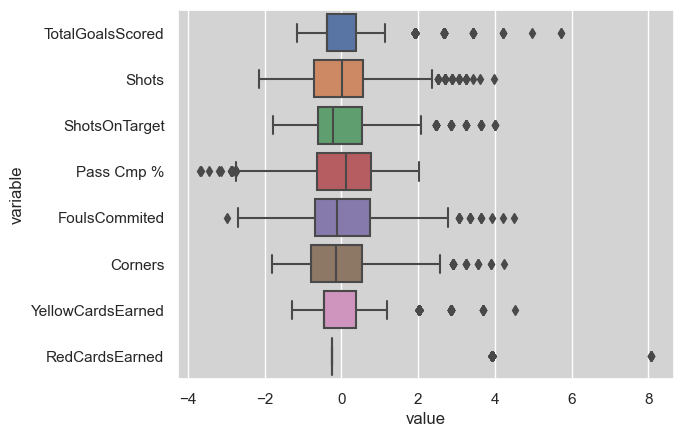

In [137]:
sns.boxplot(data=standard_metrics.melt(), y='variable', x='value');

Most of these metrics seem to have a lot of outliers on the positive side. Red cards earned especially seems to have just a few outliers, lets see what those are...

In [138]:
(metrics[['RedCardsEarned', 'Team']] # we're going back to quant_metrics so we can see the real values
 .sort_values('RedCardsEarned', ascending=False)
 .head())

,RedCardsEarned,Team
534,2,Brighton
2966,2,Chelsea
2688,2,Everton
398,2,Arsenal
399,2,Southampton


In [139]:
metrics['RedCardsEarned'].value_counts()

0    3303
1     196
2       5
Name: RedCardsEarned, dtype: int64

So what's happening is the large majority of teams are earning 0 red cards, with some earning one, even fewer earning 2, and only a single team (Newcastle) earning 3. This leads to the strange looking boxplot we saw above.

Keep in mind: These are metrics for specific matches, meaning in most matches, most teams are earning 0 red cards. Something that might be worth exploring later is seeing the distribution of total red cards for each team, or similar summed distributions for the other metrics.

Next we'll go through the quantitative metrics one by one and take a look at their distributions.

In [140]:
quant_metrics.columns # a list of all our quantitative metrics

Index(['TotalGoalsScored', 'Shots', 'ShotsOnTarget', 'Pass Cmp %',
       'FoulsCommited', 'Corners', 'YellowCardsEarned', 'RedCardsEarned'],
      dtype='object')

In [141]:
def graph_metric(metric, title=''):
    print(quant_metrics[metric].describe())
    fig = sns.histplot(data=quant_metrics,
                       x=metric,
                       bins=10)
    fig.set(title=title.title())
    return fig

#### Goals, Shots, Shots on Target

count    3504.000000
mean        1.371861
std         1.270728
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: TotalGoalsScored, dtype: float64


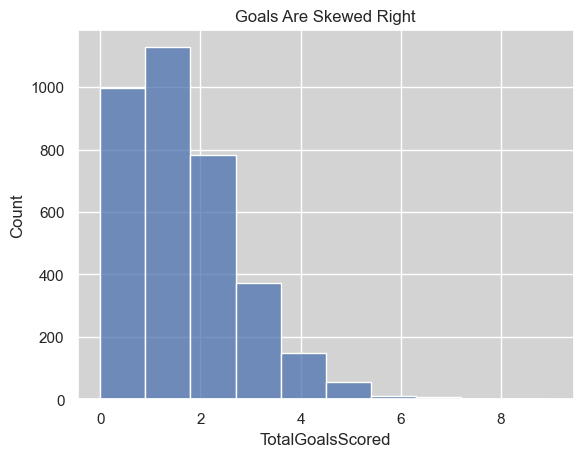

In [142]:
graph_metric('TotalGoalsScored', 'Goals are skewed right');

From this, we can tell that most teams scored around 0-2 goals in their matches, while some outliers had 5+ goals. The data is heavily skewed right.

count    3504.000000
mean       12.452626
std         5.441568
min         0.000000
25%         8.000000
50%        12.000000
75%        16.000000
max        36.000000
Name: Shots, dtype: float64


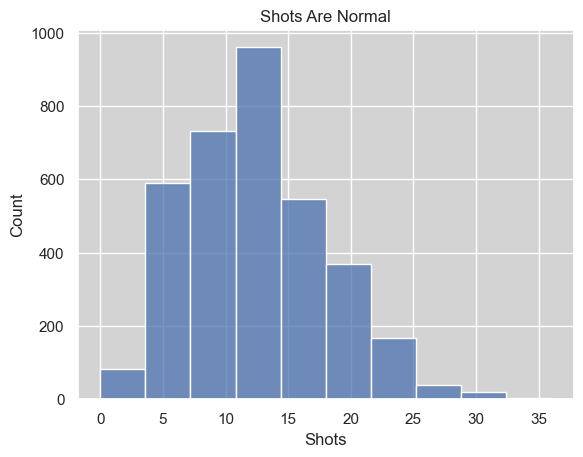

In [143]:
graph_metric('Shots', 'Shots are Normal');

Shots per match seems pretty normally distributed across teams, with a mean around 12.

count    3504.000000
mean        4.335616
std         2.549723
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        15.000000
Name: ShotsOnTarget, dtype: float64


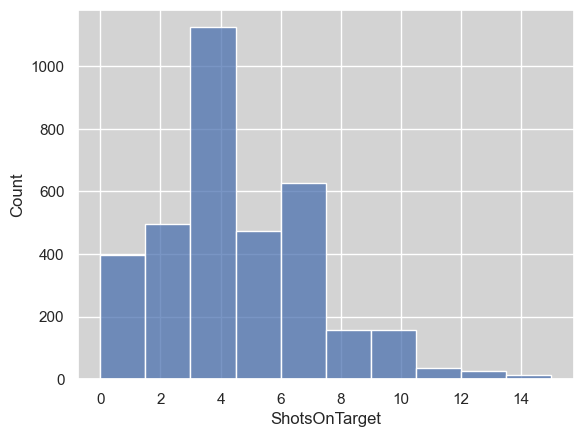

In [144]:
graph_metric('ShotsOnTarget');

However, Shots on Target (i.e. shots that were at the goal, but may or may not make it in) is more right-skewed, but still pretty normal.

So, while teams are generally taking shots normally, the shots that make it are skewed. *This suggests there are a few very high performing teams who have much higher shot accuracy, while most teams don't make nor almost make as many shots.*

In [145]:
# Who are those high-performing teams?
(metrics[['ShotsOnTarget', 'Team']]
 .sort_values('ShotsOnTarget', ascending=False)
 .head(20)
 ['Team']
 .value_counts())

Liverpool     5
Man City      4
Arsenal       3
Tottenham     3
Man United    3
Leicester     1
Chelsea       1
Name: Team, dtype: int64

This tells us out of the top 20 highest-scoring matches, Liverpool had 5, Man city had 4, and so on. These 7 prestigious teams are making up the right of our goals distributions. When we do our analysis, we'll likely have to remember the uneven distribution of goals scored and account for the high performance of these teams.

In [146]:
# What's left?
quant_metrics.columns

Index(['TotalGoalsScored', 'Shots', 'ShotsOnTarget', 'Pass Cmp %',
       'FoulsCommited', 'Corners', 'YellowCardsEarned', 'RedCardsEarned'],
      dtype='object')

#### Pass Completion

count    2302.000000
mean       77.405995
std         7.402786
min        50.200000
25%        72.700000
50%        78.400000
75%        83.100000
max        92.300000
Name: Pass Cmp %, dtype: float64


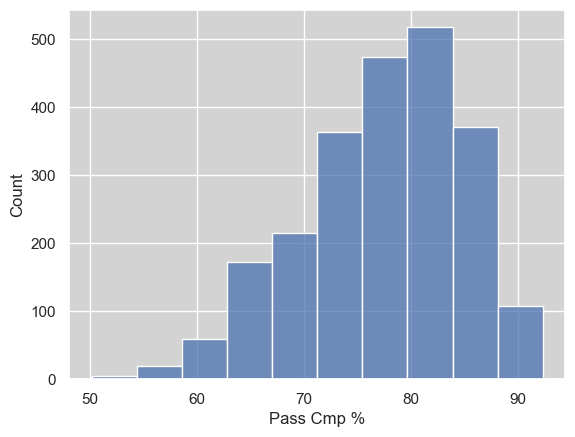

In [147]:
graph_metric('Pass Cmp %');

The data seems to be centered around 70-80% pass completion, indicating that this is the most common range for pass completion. The distribution appears to be slightly left-skewed, meaning there are fewer instances of teams with very low pass completion rates compared to high ones. However there is also a lower count of very high performing temas with regards to passing. Let's continue this analysis by looking at each teams (whose passing data is accounted for) average.



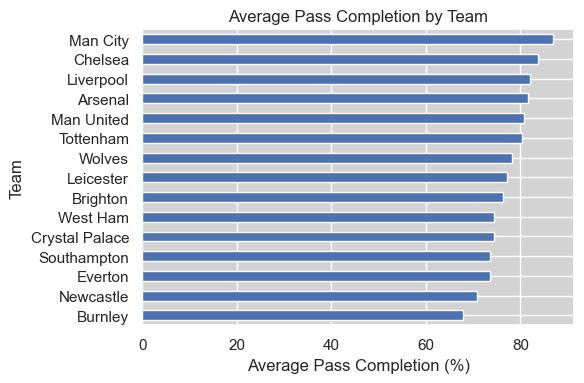

In [148]:
average_pass_cmp_per_team = metrics.dropna(subset=['Pass Cmp %']).groupby('Team')['Pass Cmp %'].mean()
plt.figure(figsize=(6, 4)) 
average_pass_cmp_per_team.sort_values().plot(kind='barh')
plt.xlabel('Average Pass Completion (%)')
plt.title('Average Pass Completion by Team')
plt.tight_layout()

# Show the plot
plt.show()

As we can see, the typically dominant teams have higher pass completion rates, which is expected. How does the passing performance correspond to total goals scored? Let's explore this, I will do so in the Bivariate Analysis section

#### Fouls and Cards

count    3504.000000
mean       10.583904
std         3.500065
min         0.000000
25%         8.000000
50%        10.000000
75%        13.000000
max        26.000000
Name: FoulsCommited, dtype: float64


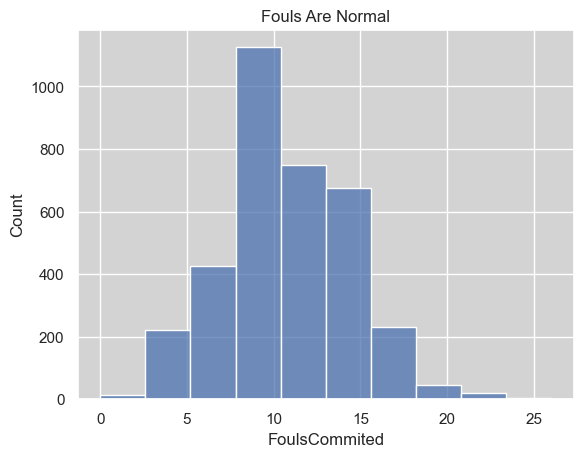

In [149]:
graph_metric('FoulsCommited', 'Fouls are normal');

Seems fouls are normally distributed, with a mean of around 11. Let's see if this is reflected in the cards:

count    3504.000000
mean        1.604452
std         1.223027
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: YellowCardsEarned, dtype: float64
count    3504.000000
mean        0.058790
std         0.241255
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: RedCardsEarned, dtype: float64


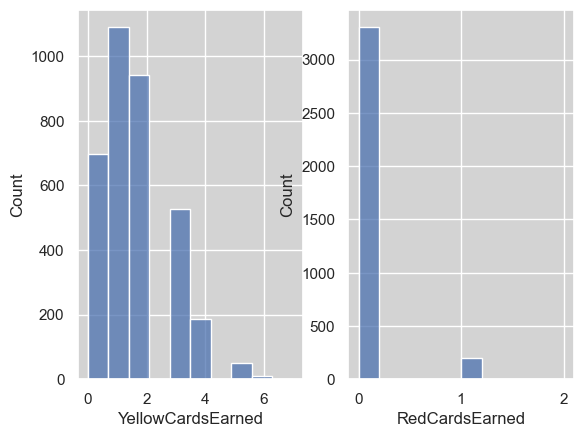

In [150]:
plt.subplot(1,2,1)
graph_metric('YellowCardsEarned')
plt.subplot(1,2,2)
graph_metric('RedCardsEarned');

The yellow cards seem right skewed actually.

In [151]:
(metrics[['Team', 'YellowCardsEarned']]
 .sort_values('YellowCardsEarned', ascending=False)
 .head(20)
 ['Team']
 .value_counts())

Leeds          3
Southampton    3
Man United     2
West Ham       2
Arsenal        2
Aston Villa    2
Burnley        1
Fulham         1
Man City       1
Stoke          1
Watford        1
West Brom      1
Name: Team, dtype: int64

There doesn't seem to be only a few teams dominating the yellow cards. It could be that the teams are playing more aggressive in the last few matches of the season, so there's a small number of matches with lots of yellow cards.

In [152]:
# what's left?
quant_metrics.columns

Index(['TotalGoalsScored', 'Shots', 'ShotsOnTarget', 'Pass Cmp %',
       'FoulsCommited', 'Corners', 'YellowCardsEarned', 'RedCardsEarned'],
      dtype='object')

#### Corners

count    3504.000000
mean        5.198630
std         2.924971
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        18.000000
Name: Corners, dtype: float64


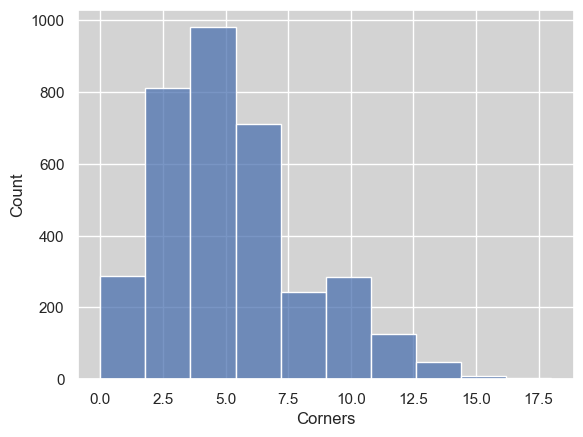

In [153]:
graph_metric('Corners');

Finally, Corners also seems a bit right skewed. Remember, this is corners earned, so this right skew is likely for the same reason as goals and shots on target: A few teams are performing at an extremely high level.

### Aside: Goal percentage
Let's create a new metric, called goal accuracy, that's just the proportion of goals scored out of all the shots taken by a team.
$$\text{Goal accuracy} = \frac{\text{Num goals scored}}{\text{Num shots taken}}$$

In [154]:
metrics['goal_acc'] = metrics['TotalGoalsScored'] / metrics['Shots']
# If they took 0 shots, goal_acc would be 0 / 0 = NaN, so we replace those with 0.0
metrics['goal_acc'] = metrics['goal_acc'].fillna(0.0)
metrics.head(3)

,Date,TotalGoalsScored,FullTimeResult,Team,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,IsHome,Won,goal_acc
0,01/01/17,0,H,Crystal Palace,7,4,NaN,7,4,1,0,False,False,0.000000
1,01/01/17,4,A,Tottenham,19,6,NaN,6,3,0,0,False,True,0.210526
2,02/01/17,0,H,Southampton,12,3,NaN,14,8,1,0,False,False,0.000000


Let's look at the distribution of our new metric:

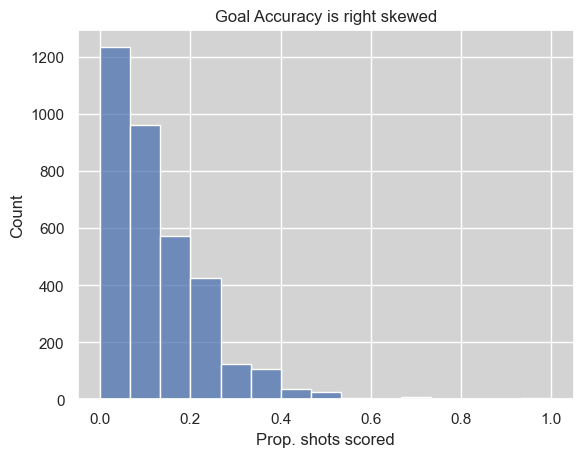

In [155]:
fig = sns.histplot(data=metrics, x='goal_acc', bins=15)
fig.set(title='Goal Accuracy is right skewed', xlabel='Prop. shots scored');

As we might have expected, this new metric is also right skewed. This is again due to the fact that there are a few high-performing teams scoring more and more often than the other teams, causing a small number of matches to have high goal accuracy.

## Qualitative Metrics
Now let's look at the distributions of the qualitative metrics. What these will tell us are which teams we have more data on, meaning which teams have stayed in the EPL the longest. It'll also give us a feel for which teams win the most, which *side* wins the most, etc.

In [156]:
qual_columns = ['FullTimeResult', 'Team', 'IsHome', 'Won']

In [157]:
qual_metrics = metrics[qual_columns + ['Date']]
qual_metrics.head()

,FullTimeResult,Team,IsHome,Won,Date
0,H,Crystal Palace,False,False,01/01/17
1,A,Tottenham,False,True,01/01/17
2,H,Southampton,False,False,02/01/17
3,H,Burnley,False,False,02/01/17
4,D,Leicester,False,NaN,02/01/17


### Full Time Result: Which side is winning more?

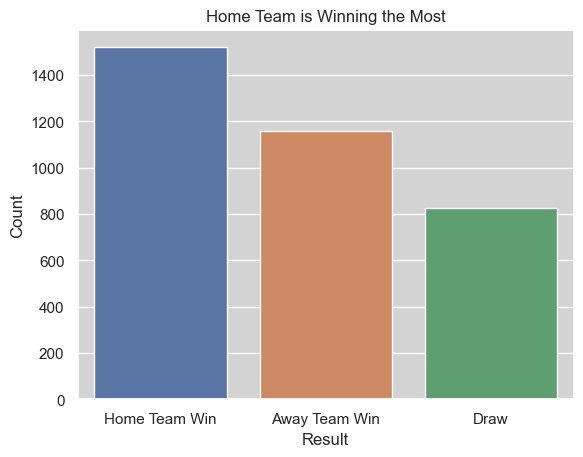

In [158]:
fig = sns.countplot(data=qual_metrics, x='FullTimeResult', order=['H', 'A', 'D'])
fig.set(title='Home Team is Winning the Most', 
        xticklabels=['Home Team Win', 'Away Team Win', 'Draw'],
        xlabel='Result',
        ylabel='Count');

As expected, the "home court advantage" holds precedence. Does this change based on the team?

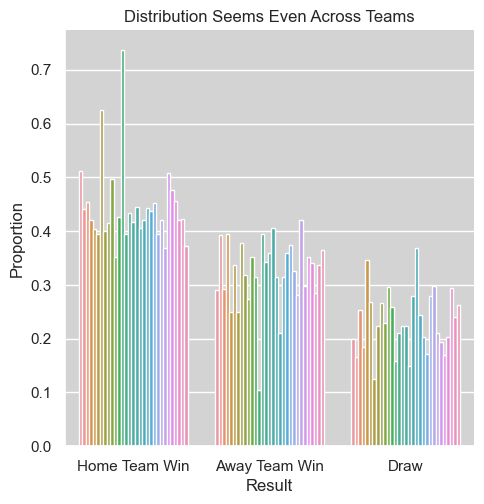

In [159]:
# Since each team has a different number of wins, we need to normalize the distributions first.
norm_result_df = (qual_metrics
                     .groupby('Team')['FullTimeResult']
                     .apply(lambda df: df.value_counts(normalize=True))
                     .reset_index())
normalized_result = (norm_result_df
                     .pipe((sns.catplot,'data'), 
                       x='level_1',
                       y='FullTimeResult',
                       hue='Team',
                       kind='bar',
                       legend=False)) # I removed the legend because it was huge and we don't really care about specific teams here
normalized_result.set(title='Distribution Seems Even Across Teams',
                      xticklabels=['Home Team Win', 'Away Team Win', 'Draw'],
                        xlabel='Result',
                        ylabel='Proportion');

This graph shows that across all teams (each team being a sub-bar), *the proportions of games that are Home wins, Away wins, and Draws are about the same*. There are one or two teams that stand out, but overall the distribution seems pretty even. Still, we should proabbly keep those outliers in mind.

In [160]:
(norm_result_df
 .groupby('level_1')
 .apply(
     lambda df: (df
                 .set_index('Team')
                 .sort_values('FullTimeResult')
                 .index[:3]
                 )
     )
 )

level_1
A    Index(['Hull', 'Middlesbrough', 'Brighton'], d...
D    Index(['Cardiff', 'Man City', 'Hull'], dtype='...
H    Index(['Fulham', 'Sunderland', 'Wolves'], dtyp...
dtype: object

This output tells us that the 3 teams with the highest proportions of Away wins were Hull, Middlesbrough, and Brighton (and similar for Draws and Home wins). We'll have to pay careful attention to these outliers.

### Teams: Who's stayed in the EPL? Who is our data representing?
Let's take a look to see which teams are most represented by the metrics data we have.

[Text(0.5, 1.0, 'With this many teams, a bar plot is hard to read')]

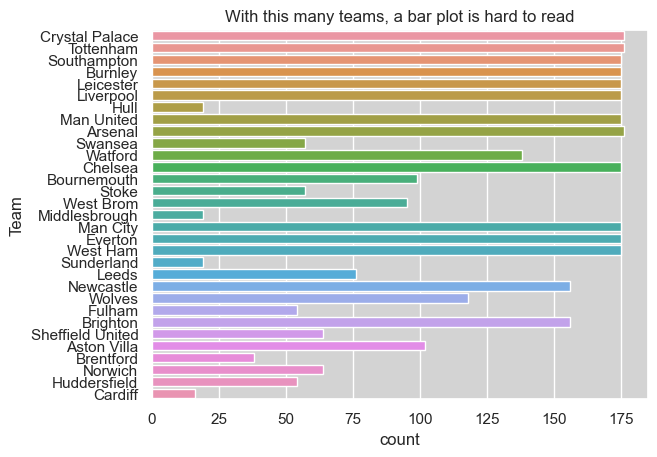

In [161]:
fig = sns.countplot(y=qual_metrics['Team']);
fig.set(title = 'With this many teams, a bar plot is hard to read')

In [162]:
team_counts = qual_metrics['Team'].value_counts()
team_counts.head(10)

Crystal Palace    176
Arsenal           176
Tottenham         176
Man City          175
Southampton       175
Burnley           175
Leicester         175
Liverpool         175
Man United        175
Chelsea           175
Name: Team, dtype: int64

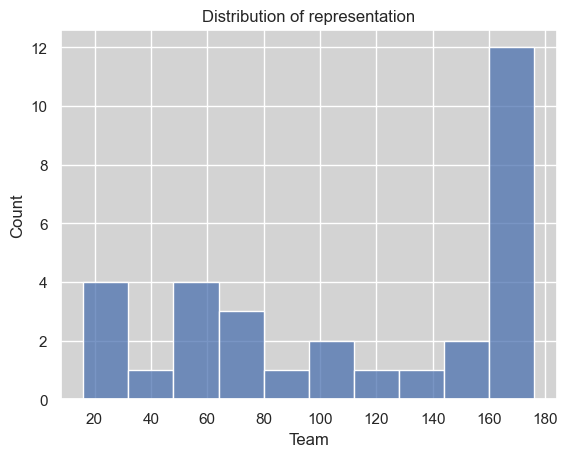

In [207]:
fig = sns.histplot(team_counts, bins=10)
fig.set(title='Distribution of representation');

This histogram graphs the distribution of representation in our dataset. As can be seen, there is a peak at the right end. This means that there are 12 teams who make up the bulk of our dataset, and whose metrics are overrepresented. We'll have to remember this for our later analysis, and remember to normalize metrics for each team so we're looking at true changes in performance, and not just raw numbers.

# Bivariate Analysis

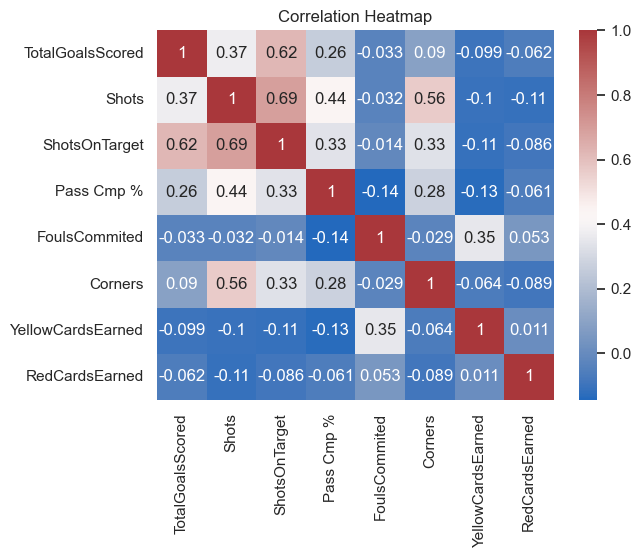

In [218]:
heat = sns.heatmap(metrics[quant_columns].corr(), annot=True, cmap=sns.color_palette('vlag', as_cmap=True))
heat.set(title = 'Correlation Heatmap');

This gives us the correlation coefficient for all the quantitative metrics: The farther from 0, the more correlated, while the sign indicates the direction. Let's take a look at all pairs of metrics with a strong (>0.5) correlation (and one other surprising result).

### Shots vs. Goals
>**You miss 100% of the shots you don't take.**
<br>*-Wayne Gretzky*
<br>*~~-Michael Scott~~*

Does taking more shots make you more likely to score more goals? This could influence our analysis, as if this is true, then there would exist multicollinearity in our dataset between shots and goals. The correlation was surprisingly low for these two metrics: let's take a look to check our intuition.

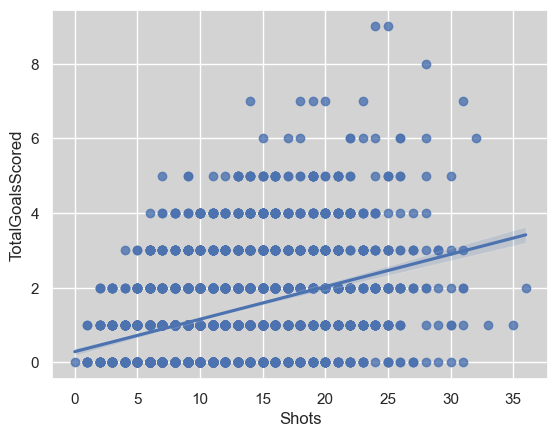

In [165]:
sns.regplot(data=metrics, x='Shots', y='TotalGoalsScored');

In [166]:
linmod = LinearRegression()
X = metrics[['Shots']]
y = metrics['TotalGoalsScored']
linmod.fit(X, y)
linmod.score(X, y)

0.13852245345396408

Clearly, these two metrics don't have a very strong linear relationship.

### Shots on Target vs. Goals
These two metrics had a higher correlation (0.622), so let's do the same for them. 

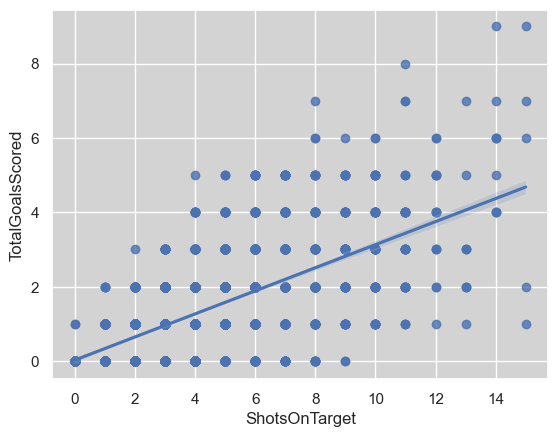

In [167]:
sns.regplot(data=metrics, x='ShotsOnTarget', y='TotalGoalsScored');

*This grid-like pattern is to be expected, since both metrics are only measured in whole numbers.*

In [168]:
# reports the R^2 score for a linear model
linmod = LinearRegression()
X = metrics[['ShotsOnTarget']]
y = metrics['TotalGoalsScored']
linmod.fit(X, y)
linmod.score(X, y)

0.3874494453266607

Looking at the graph, they definitely feel more correlated than just shots and goals. Running and evaluating a linear model also supports this idea: the  $R^2$ score is higher. We might have to watch out for this in our final analysis.

#### Shots vs. Shots on Target

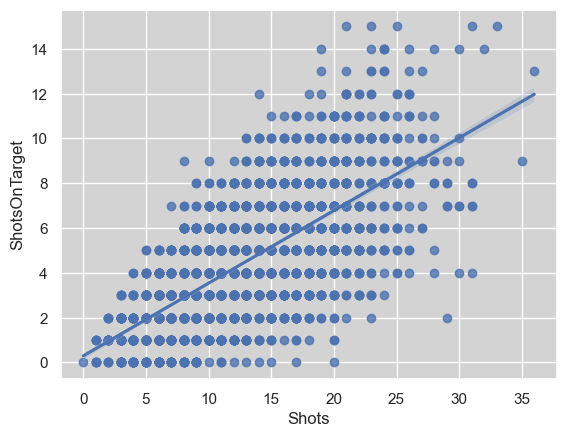

In [169]:
sns.regplot(data=metrics, x='Shots', y='ShotsOnTarget');

In [170]:
# reports the R^2 score for a linear model
linmod = LinearRegression()
X = metrics[['Shots']]
y = metrics['ShotsOnTarget']
linmod.fit(X, y)
linmod.score(X, y)

0.47900323933535904

This tells us taking more shots does strongly correlate with your shots on target.

#### Corners vs. Shots
There's one last relationship to investigate with strong (0.5 - 1.0) correlation: Corners and shots taken.

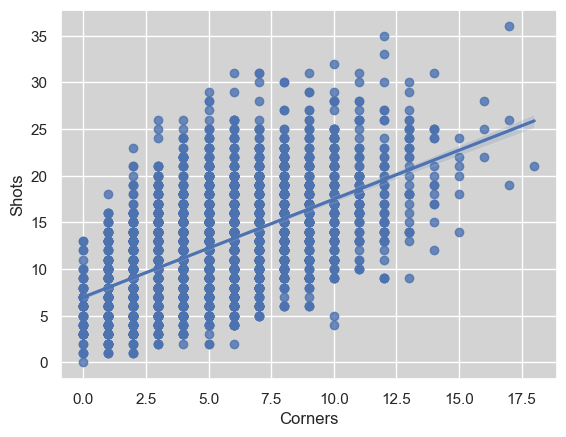

In [171]:
sns.regplot(data=metrics, x='Corners', y='Shots');

In [172]:
# reports the R^2 score for a linear model
linmod = LinearRegression()
X = metrics[['Corners']]
y = metrics['Shots']
linmod.fit(X, y)
linmod.score(X, y)

0.3180963562612781

The strong relationship here could be attributed to more opportunities being opened after being awarded a corner kick. Or the other way: The more shots are taken, the more chances to get awarded, if a defender kicks the shot out of bounds.

#### Goals vs Pass Completion

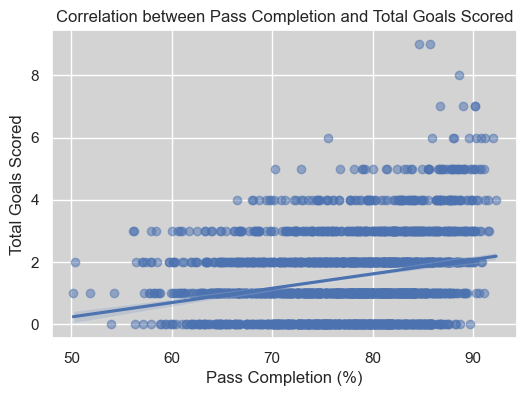

In [173]:
metrics_with_pass_cmp = metrics.dropna(subset=['Pass Cmp %'])

plt.figure(figsize=(6, 4))
sns.regplot(x='Pass Cmp %', y='TotalGoalsScored', data=metrics_with_pass_cmp, scatter_kws={'alpha':0.5})
plt.title('Correlation between Pass Completion and Total Goals Scored')
plt.xlabel('Pass Completion (%)')
plt.ylabel('Total Goals Scored')

plt.show()

The upward slope of the regression line suggests there is a positive correlation between pass completion and the total goals scored. As pass completion increases, total goals scored also tend to increase. While there is a positive trend, the pass completion rate alone may not be a strong predictor of the number of goals scored due to the high variance observed in the data, we can see that there are quite a few outliers, who had a good cmp, with a total goals count being much higher than other clubs with similar pass cmp results.

##### Lets quantify the stength between these two statistics

In [174]:
correlation_coefficient = metrics_with_pass_cmp['Pass Cmp %'].corr(metrics_with_pass_cmp['TotalGoalsScored'])

print(f"The Pearson correlation coefficient between pass completion and total goals scored is: {correlation_coefficient}")

The Pearson correlation coefficient between pass completion and total goals scored is: 0.26067361269236344


As we can see, the correlation between these two does exist and it is positive, but it is weaker than one might expect, indicating that a team's passing completion rate does not have as much of an impact on goals scored as I thought it would, interesting! I will continue the exploaration of this passing statistic, analyzing it over time.

### Quantitative metrics over time
Something that might be interesting is tracking how these metrics change from match to match. Since we have the dates, we can graph these metrics over the time period we have.

We'll start with goals, just to check if our methods are worthwhile.

In [241]:
# converting date to datetime
quant_time = metrics[quant_columns + ['Date']].copy()
quant_time['Date'] = pd.to_datetime(quant_time['Date'], format='%d/%m/%y')
quant_time.head()

,TotalGoalsScored,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,Date
0,0,7,4,NaN,7,4,1,0,2017-01-01
1,4,19,6,NaN,6,3,0,0,2017-01-01
2,0,12,3,NaN,14,8,1,0,2017-01-02
3,1,11,3,NaN,11,8,3,0,2017-01-02
4,0,10,4,NaN,9,2,0,0,2017-01-02


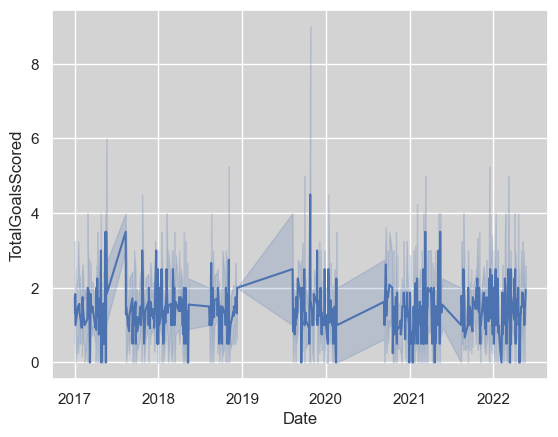

In [242]:
sns.lineplot(data=quant_time, x='Date', y='TotalGoalsScored');

Problem: we have so much data that this takes a long time and is very unhelpful. Let's zoom into the past 10 years for now.

In [243]:
past_10 = quant_time[quant_time['Date'].dt.year >= 2014]
past_10['Date'].dt.year.unique()

array([2017, 2020, 2021, 2022, 2019, 2018])

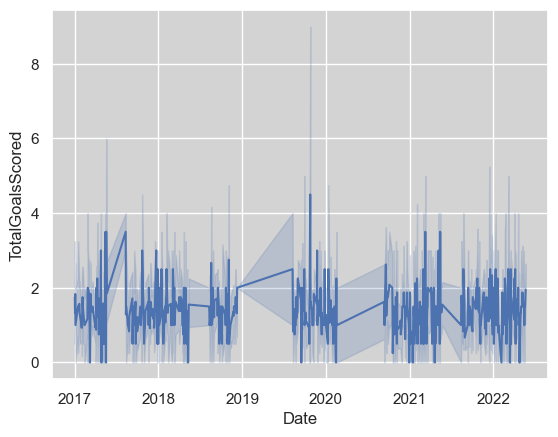

In [244]:
sns.lineplot(data=past_10, x='Date', y='TotalGoalsScored');

This may look random, but that actually makes sense: Right now, we're just looking at the goals scored for all teams across their matches, so it would be pretty random and have no clear trend, unless all the teams were improving in unison. Let's look at the pass completion metric over time. 



Text(0.5, 0, 'Progression in time from 2017-2022')

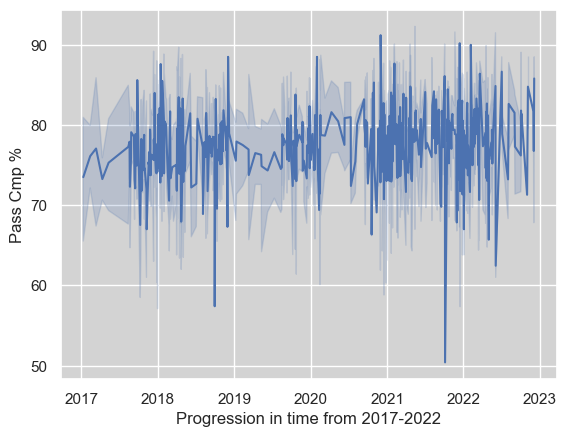

In [245]:

sns.lineplot(data=metrics_with_pass_cmp, x='Date', y='Pass Cmp %')
plt.xlabel('Progression in time from 2017-2022')

Woah, that is one crazy graph. Similarly to above, we are looking at this metric for all teams across the years. Let's clean this up by using a teams average and how it changes from year to year. 

/var/folders/sj/59v4c3dd1r1brq_2d_bjy80w0000gn/T/ipykernel_29543/1237730632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_with_pass_cmp['Date'] = pd.to_datetime(metrics_with_pass_cmp['Date'], format='%d/%m/%y')
/var/folders/sj/59v4c3dd1r1brq_2d_bjy80w0000gn/T/ipykernel_29543/1237730632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_with_pass_cmp['Year'] = metrics_with_pass_cmp['Date'].dt.year


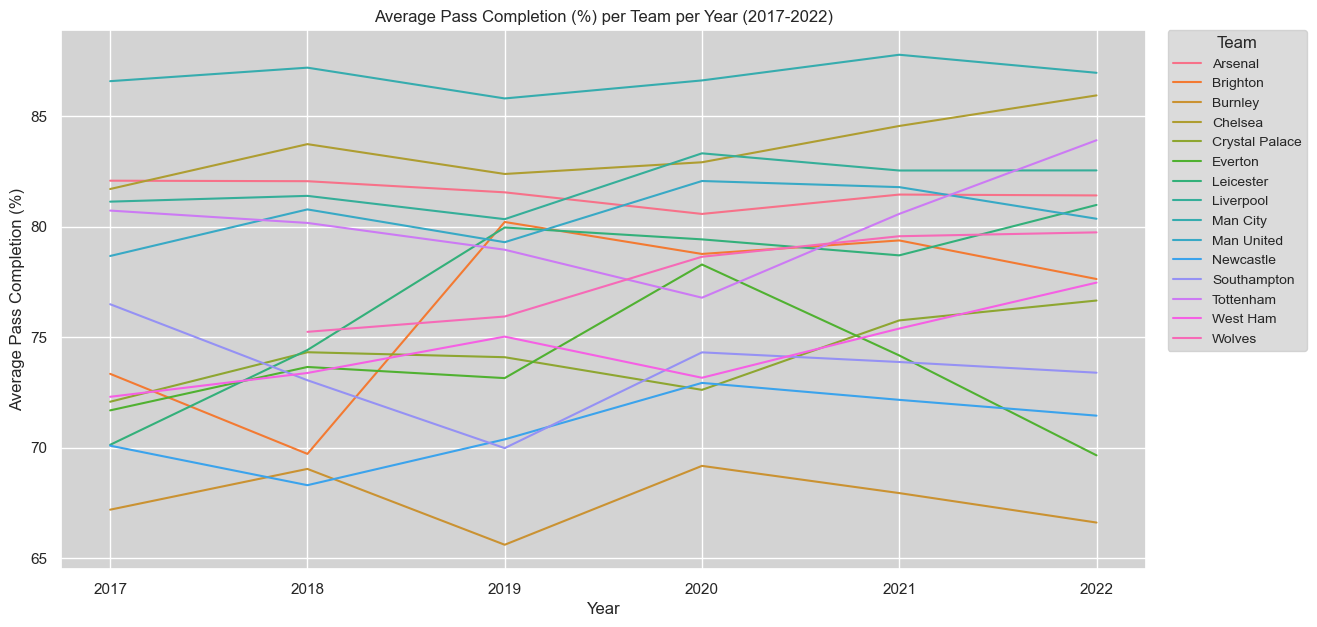

In [236]:
metrics_with_pass_cmp['Date'] = pd.to_datetime(metrics_with_pass_cmp['Date'], format='%d/%m/%y')
metrics_with_pass_cmp['Year'] = metrics_with_pass_cmp['Date'].dt.year
team_yearly_avg = metrics_with_pass_cmp.groupby(['Team', 'Year'])['Pass Cmp %'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=team_yearly_avg, x='Year', y='Pass Cmp %', hue='Team')
plt.legend(title='Team', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad= 0, fontsize='small')
plt.title('Average Pass Completion (%) per Team per Year (2017-2022)')
plt.ylabel('Average Pass Completion (%)')
plt.xlabel('Year')
plt.show()

Much better! We might be able to glean more information by looking at individual teams.

In [237]:
# pick the team with the most data, for now
metrics['Team'].value_counts().idxmax()

'Crystal Palace'

In [238]:
arsenal_metrics = metrics[metrics['Team'] == 'Arsenal']
arsenal_quant_time = arsenal_metrics[quant_columns + ['Date']].copy()
arsenal_quant_time['Date'] = pd.to_datetime(arsenal_quant_time['Date'], format='%d/%m/%y')
arsenal_quant_time.head()

,TotalGoalsScored,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,Date
8,3,14,4,NaN,12,7,3,0,2017-01-03
16,4,14,6,NaN,8,2,0,0,2017-01-14
42,1,9,5,NaN,8,13,1,0,2017-02-04
71,1,7,3,NaN,15,3,2,0,2017-03-04
90,1,11,2,NaN,6,5,0,0,2017-03-18


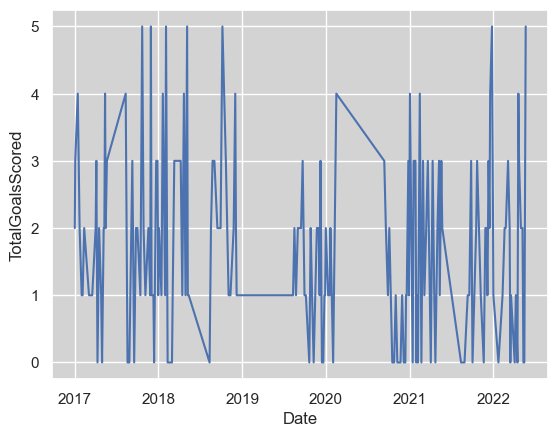

In [239]:
sns.lineplot(data=arsenal_quant_time, y='TotalGoalsScored', x='Date');

We do (vaguely) see some spikes and valleys. The idea is these could correspond to changes in manager.

Let's test that theory a bit: 

In [240]:
managers[managers['Club'] == 'Arsenal']

,Club,Predecessor,Join date,Coach
19,Arsenal,Stewart Houston,15/6/1995,Bruce Rioch
23,Arsenal,George Graham,21/2/1995,Stewart Houston
35,Arsenal,Bruce Rioch,30/6/1996,Stewart Houston
49,Arsenal,Pat Rice,30/9/1996,Arsène Wenger
50,Arsenal,Stewart Houston,13/9/1996,Pat Rice
302,Arsenal,Arsène Wenger,30/6/2018,Unai Emery
340,Arsenal,Freddie Ljungberg,21/12/2019,Mikel Arteta
345,Arsenal,Unai Emery,29/11/2019,Freddie Ljungberg


Looks like Arsenal had some manager changes in 2019. We can zoom into our metrics in 2019 and see if there was an effect.

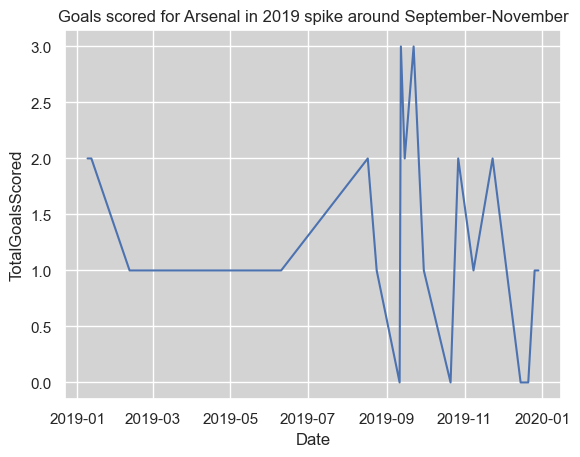

In [185]:
# Zooming into 2019
arsenal_qt_2019 = arsenal_quant_time[arsenal_quant_time['Date'].dt.year == 2019]
fig = sns.lineplot(data=arsenal_qt_2019, y='TotalGoalsScored', x='Date') # just goals
fig.set(title='Goals scored for Arsenal in 2019 spike around September-November');

Again, there are some pretty significant spikes in this graph. Do they also occur in other metrics? Let's take a loot at Arsenals passing performance, and see if it aligns. Then, we will look at all of the metrics together.

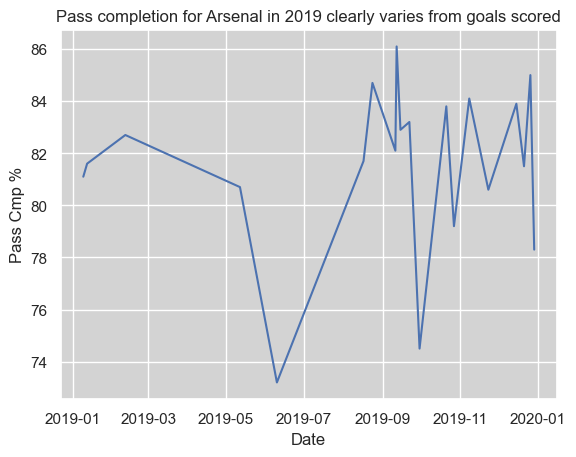

In [186]:
fig = sns.lineplot(data=arsenal_qt_2019, y='Pass Cmp %', x='Date') # just passing cmp
fig.set(title='Pass completion for Arsenal in 2019 clearly varies from goals scored');

Intrestingly enough, there was a massive dip between May and July in pass completion. Does this correlate with the other metrics, let's graph this metric, total goals scored, and now the rest of the metrics as well.

I am going to normalize the pass completion to be between zero and one, so it doesn't disrupt the scaling of the graph below.

/var/folders/sj/59v4c3dd1r1brq_2d_bjy80w0000gn/T/ipykernel_29543/2491694313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arsenal_qt_2019['Pass Cmp % Scaled'] = (arsenal_qt_2019['Pass Cmp %'] - pass_cmp_min) / (pass_cmp_max - pass_cmp_min)


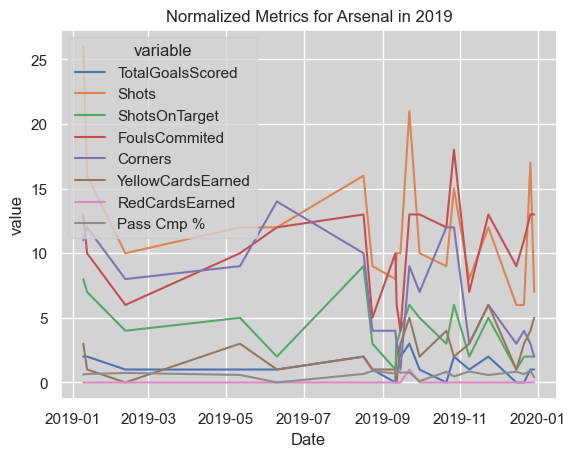

In [187]:
# Min-Max scale the 'Pass Cmp %' column to a 0-1 range
pass_cmp_min = arsenal_qt_2019['Pass Cmp %'].min()
pass_cmp_max = arsenal_qt_2019['Pass Cmp %'].max()
arsenal_qt_2019['Pass Cmp % Scaled'] = (arsenal_qt_2019['Pass Cmp %'] - pass_cmp_min) / (pass_cmp_max - pass_cmp_min)

arsenal_2019_for_plot = arsenal_qt_2019.copy()
arsenal_2019_for_plot['Pass Cmp %'] = arsenal_qt_2019['Pass Cmp % Scaled']

arsenal_2019_melted = arsenal_2019_for_plot.melt(id_vars='Date', 
                                                  value_vars=['TotalGoalsScored', 'Shots', 'ShotsOnTarget', 
                                                              'FoulsCommited', 'Corners', 'YellowCardsEarned', 
                                                              'RedCardsEarned', 'Pass Cmp %'])

# Now plot the normalized 'Pass Cmp %' with other metrics
fig = sns.lineplot(data=arsenal_2019_melted, x='Date', y='value', hue='variable')
fig.set(title='Normalized Metrics for Arsenal in 2019')
plt.show()

# fig = sns.lineplot(data=arsenal_qt_2019.melt('Date'), x='Date', y='value', hue='variable')
# fig.set(title='All metrics jump around late September, October, November, December');

In [188]:
managers[(managers['Club'] == 'Arsenal') & (managers['Join date'].str[-4:] == '2019')]

,Club,Predecessor,Join date,Coach
340,Arsenal,Freddie Ljungberg,21/12/2019,Mikel Arteta
345,Arsenal,Unai Emery,29/11/2019,Freddie Ljungberg


Here we see something promising: All our metrics jumped up somewhere in late November of 2019, which is when Freddie Ljungberg took over for Unai Emery. The same happened at the end of December - but also at the end of September and October, when there were no changes in manager. Curious.

Let's look at which teams are changing their managers the most, and also let's find out the average number of managerial changes across all teams. Mabye then we look at a team that has changed their manager around the average number of times, and compare its metrics alongside one that has only changed it a few times.

In [189]:
num_of_managerial_changes_per_team = managers['Club'].value_counts()
print(num_of_managerial_changes_per_team.head(5))
print()
average_managerial_changes = num_of_managerial_changes_per_team.mean()
print(f"Teams are changing their manager an average of {average_managerial_changes} times.")

Tottenham      25
Chelsea        24
Southampton    24
Newcastle      24
Aston Villa    22
Name: Club, dtype: int64

Teams are changing their manager an average of 8.891304347826088 times.


In [190]:
teamsWithTenOrLessChanges = num_of_managerial_changes_per_team[num_of_managerial_changes_per_team <= 10]
teamsWithTenOrLessChanges

Swansea                10
Arsenal                 8
Man United              8
Bolton                  7
Liverpool               7
Norwich                 6
Wigan                   5
Sheffield Wednesday     5
Birmingham              5
Hull                    5
Wolves                  5
QPR                     5
Nottingham Forest       5
Burnley                 4
Derby                   4
Middlesbrough           4
Stoke                   4
Brighton                3
Bournemouth             3
Charlton                3
Coventry                3
Wimbledon (- 2004)      2
Ipswich                 2
Reading                 2
Cardiff                 2
Huddersfield            2
Sheffield               2
Bradford                2
Swindon                 1
Name: Club, dtype: int64

In [191]:
managers[managers['Club'] == 'Man United']

,Club,Predecessor,Join date,Coach
224,Man United,Sir Alex Ferguson,30/6/2013,David Moyes
238,Man United,David Moyes,22/4/2014,Louis van Gaal
275,Man United,Louis van Gaal,23/5/2016,José Mourinho
325,Man United,Ole Gunnar Solskjær,28/3/2019,Ole Gunnar Solskjær
332,Man United,José Mourinho,18/12/2018,Ole Gunnar Solskjær
361,Man United,Ralf Rangnick,31/5/2022,Erik ten Hag
367,Man United,Michael Carrick,3/12/2021,Ralf Rangnick
368,Man United,Ole Gunnar Solskjær,21/11/2021,Michael Carrick


Man United is another team that has changed managers roughly around the average amount. Specifically, let's look at the transition from Mourinho to Ole because this took the club from managerial stability for a decent period of time (close to three years) and represented a significant shift in coaching style. Mourinho was very pragmatic and results-focused in his style of play and prioritized winning over "pretty football." Mourinho also had boatloads of experience with winning major honours with other big clubs before he took the Man United job. On the other hand, Ole was a club legend (as a player) who was very new to management and whose style of play was more free-flowing and risky. His appointment also represented a culture-shift around the club, as players and fans alike were excited to have a popular ex-player in charge. All this to say, I think it would be very useful to look at this managerial change since it is representative of a genuine shift in philosiphy and culture. 

In [231]:
manU_metrics = metrics[metrics['Team'] == 'Man United']
manU_quant_time = manU_metrics[quant_columns + ['Date']].copy()
manU_quant_time['Date'] = pd.to_datetime(manU_quant_time['Date'], format='%d/%m/%y')
manU_quant_time.head()

,TotalGoalsScored,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,Date
7,2,13,6,NaN,13,1,2,0,2017-01-02
27,1,25,8,NaN,13,7,0,0,2017-01-21
50,3,15,9,NaN,13,3,4,0,2017-02-05
93,3,14,6,NaN,8,3,1,0,2017-03-19
123,3,18,9,NaN,20,5,5,0,2017-04-09


Ole was appointed mid-December of 2018, so let's look specifically at the end of 2018, and the year of 2019.

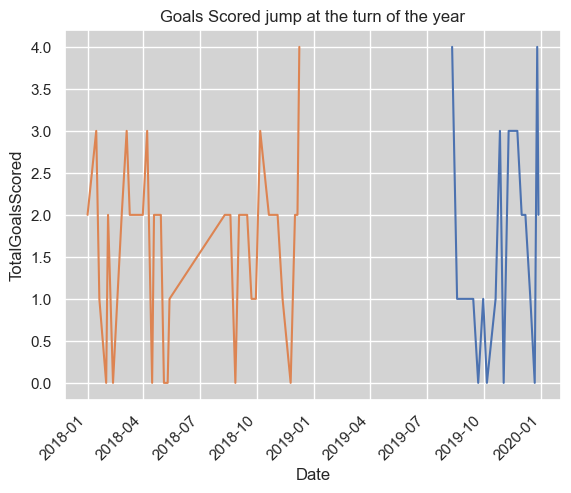

In [232]:
manU_qt_2019 = manU_quant_time[manU_quant_time['Date'].dt.year == 2019]
manU_qt_2018 = manU_quant_time[manU_quant_time['Date'].dt.year == 2018]
fig = sns.lineplot(data=manU_qt_2019, y='TotalGoalsScored', x='Date') # just goals
fig2 = sns.lineplot(data=manU_qt_2018, y = 'TotalGoalsScored', x='Date')
plt.xticks(rotation=45, ha = 'right')
fig.set(title='Goals Scored jump at the turn of the year');

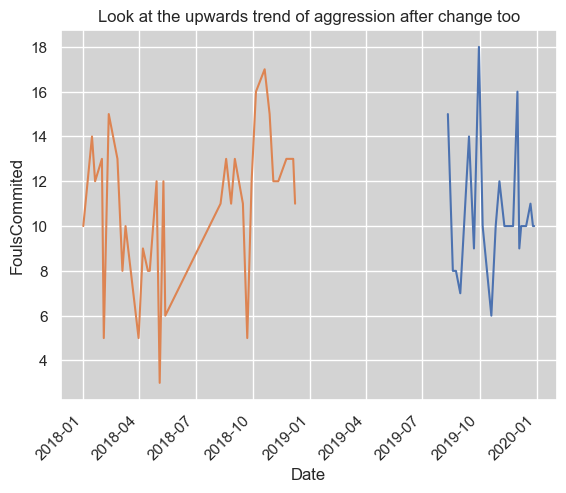

In [233]:
fig = sns.lineplot(data=manU_qt_2019, y='FoulsCommited', x='Date') # just goals
fig2 = sns.lineplot(data=manU_qt_2018, y = 'FoulsCommited', x='Date')
plt.xticks(rotation=45, ha = 'right')
fig.set(title='Look at the upwards trend of aggression after change too');

### Metrics by Team
Let's break down some other metrics by teams and see how different they are.

In [234]:
metrics_by_team = metrics.groupby('Team').mean().reset_index()
metrics_by_team.head(3)

,Team,TotalGoalsScored,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,IsHome,goal_acc,PointsWonByResult
0,Arsenal,1.698864,13.880682,4.960227,81.541026,10.113636,5.846591,1.681818,0.090909,0.505682,0.130549,1.698864
1,Aston Villa,1.382353,12.774510,4.539216,NaN,11.156863,5.362745,1.843137,0.058824,0.500000,0.113673,1.225490
2,Bournemouth,1.262626,11.555556,3.939394,NaN,9.020202,5.161616,1.565657,0.070707,0.515152,0.108931,1.161616


In [235]:
metrics_by_team.describe().T

,count,mean,std,min,25%,50%,75%,max
TotalGoalsScored,31.0,1.213840,0.459598,0.526316,0.924890,1.096591,1.396891,2.520000
Shots,31.0,11.868896,2.076744,9.105263,10.594161,11.555556,12.641541,17.822857
ShotsOnTarget,31.0,4.016202,0.972848,2.684211,3.269955,3.722222,4.532465,6.520000
Pass Cmp %,15.0,77.419137,5.159094,67.754487,73.980769,77.192308,81.111859,86.985256
FoulsCommited,31.0,10.737768,0.971102,9.020202,9.963068,10.842105,11.278045,13.000000
Corners,31.0,4.961368,0.825724,3.421053,4.390326,4.772727,5.369944,7.588571
YellowCardsEarned,31.0,1.650680,0.196744,1.160000,1.556674,1.617143,1.738558,2.118421
RedCardsEarned,31.0,0.061952,0.029017,0.017544,0.046295,0.057143,0.076617,0.157895
IsHome,31.0,0.502467,0.015449,0.473684,0.495731,0.500000,0.506046,0.562500
goal_acc,31.0,0.106297,0.025225,0.047703,0.093692,0.104511,0.120927,0.149399


This chart gives us the team-wise summary stats instead of the full match-per-team-wise stats we had before. Notice the means are actually very close to our original stats: This is expected, since they're just the mean of means. What is more interesting is the variance: We can see that shots had a very high variance from row 2 column 3 of the chart, meaning the average number of shots per match varied widely from team to team.

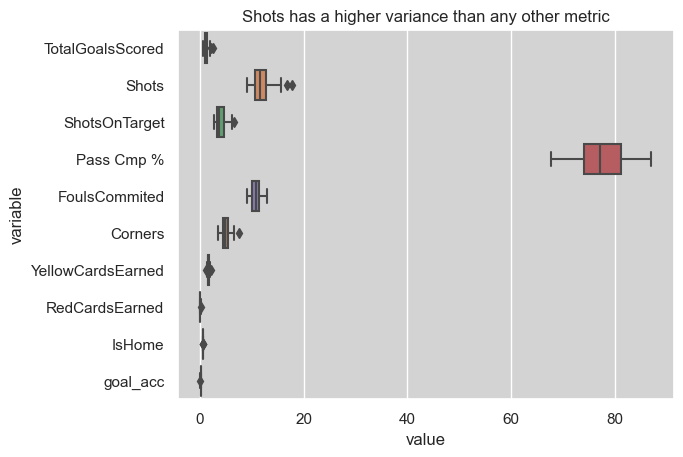

In [197]:
fig = sns.boxplot(data=metrics_by_team.drop(columns=['Team']).melt(), y='variable', x='value')
fig.set(title='Shots has a higher variance than any other metric');

#### Relationships in Metrics by Team
Now that we've broken things down by team, we can get a much better look at the relationships between different metrics. Since we're using average metrics by teams, no single team's stats will be overrepresented, which should hopefully eliminate some biases.

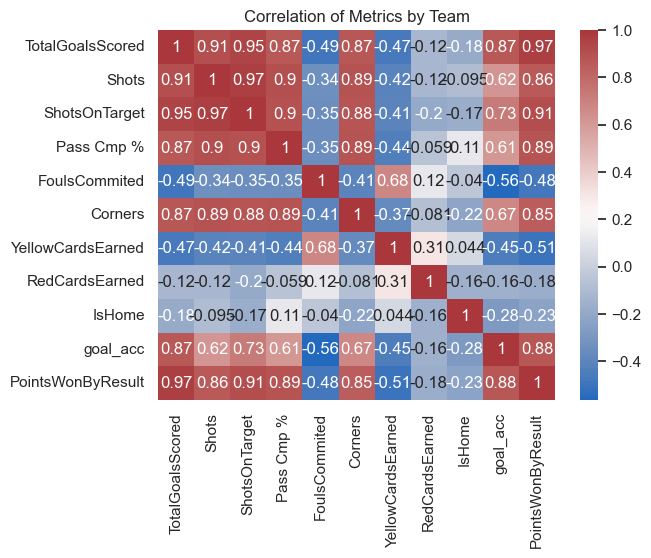

In [216]:
heat = sns.heatmap(metrics_by_team.corr(), annot=True, cmap=sns.color_palette('vlag', as_cmap=True))
heat.set(title='Correlation of Metrics by Team');

We can see that there are a lot more strong relationships to be found, even relationships we didn't see before! For example, we can see a huge increase in the correlation between corners and total goals scored. This is probably because the higher-performing teams were scoring regardless of whether they were awarded corners or not, which reduced the correlation in the overall dataset. We can also see a strong *negative* correlation between fouls commited and goals scored/goal accuracy, and a moderate negative correlation for other foul metrics (cards earned). This could mean that more aggression doesn't necessarily mean higher performance as far as goals scored.

In [199]:
# The correlation matrix tells us most of what we need to know, but it might be worthwhile to graph a few of these just to check...
# sns.scatterplot(data=metrics_by_team, x='Corners', y='ShotsOnTarget'); # Uncomment to graph

Side note: IsHome seems to have a weak negative correlation with TotalGoals, even though we saw earlier that the home team was more likely to win. This is simply because most teams have around a 50% proportion of games where they were the home team, and the few teams that played more home games tended to score low in terms of goals.

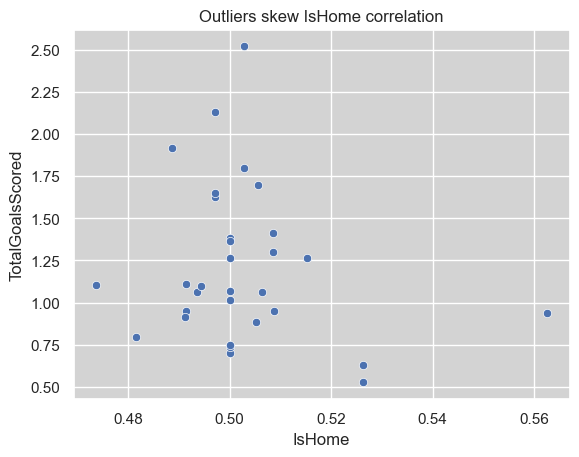

In [200]:
home_paradox = sns.scatterplot(data=metrics_by_team, x='IsHome', y='TotalGoalsScored');
home_paradox.set(title='Outliers skew IsHome correlation');

#### Goals Scored by Team
With this data, let's see if we can verify the speculation we had earlier: that there are a few teams with much higher average goals scored than the rest.

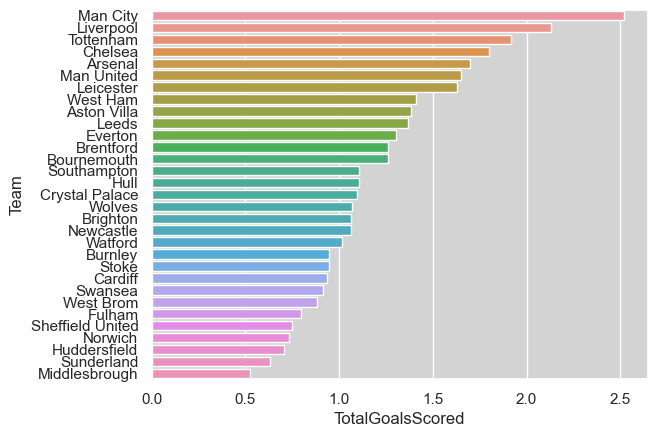

In [201]:
sns.barplot(data=metrics_by_team.sort_values('TotalGoalsScored', ascending=False),
            y='Team', 
            x='TotalGoalsScored');

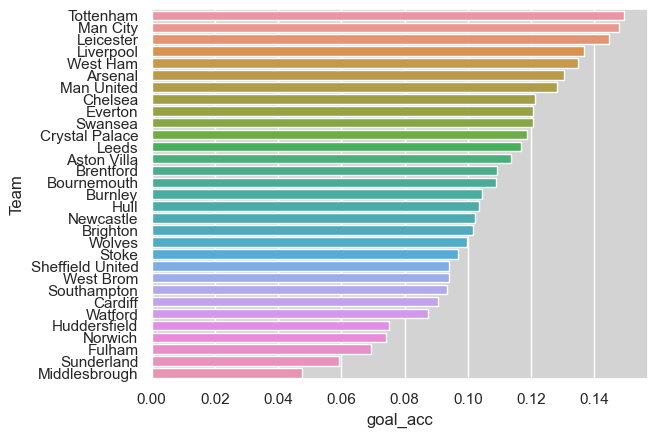

In [202]:
sns.barplot(data=metrics_by_team.sort_values('goal_acc', ascending=False),
            y='Team', 
            x='goal_acc');

This further verifies our speculation to the skewedness of goals data from before. The top teams are scoring far higher (with far higher accuracy) than the bottom teams.

### Metric Contribution to Win
A huge part of our analysis is to look at which specific metrics managerial changes are influencing that lead to higher win rates. Let's see if we can, from this dataset, explore which metrics are most important for a win. That way we'll know which metrics to look for changes in when analyzing the effect of manager changes.

To do this, we'll use the `Won` column in `metrics`. Currently, it has the value `True` if the team won that match, `False` if not, and `NaN` if it was a draw.

To properly do this analysis, we'll need to convert it all to numerical data, using the [three-points for a win](https://en.wikipedia.org/wiki/Three_points_for_a_win#:~:text=Three%20points%20for%20a%20win%20is%20a%20standard%20used%20in,each%20team%20receives%20one%20point.) system. This is so that teams are rewarded for draws, as they would be in the real world, instead of setting draws to be 0, same as losses.

TODO: Add more details about this system

In [203]:
metrics['Won'].head()

0    False
1     True
2    False
3    False
4      NaN
Name: Won, dtype: object

In [204]:
# Creating PWBR column to represent point result of match
result_points = metrics['Won'].replace({
    True: 3.0,
    False: 0.0
}).fillna(1.0)
metrics['PointsWonByResult'] = result_points
metrics['PointsWonByResult'].head()

0    0.0
1    3.0
2    0.0
3    0.0
4    1.0
Name: PointsWonByResult, dtype: float64

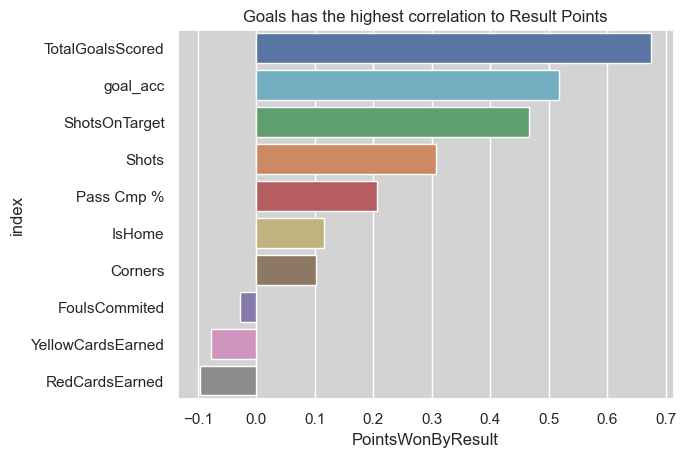

In [205]:
correlation_to_PWBR = metrics.corr()[['PointsWonByResult']].drop('PointsWonByResult').reset_index()
# defining a custom palette to have consistency
unique_metric_names = correlation_to_PWBR['index'].unique()
PWBR_palette = dict(zip(unique_metric_names, sns.color_palette()))
correl = sns.barplot(data=correlation_to_PWBR.sort_values('PointsWonByResult', ascending=False),
                   y='index', x='PointsWonByResult', palette=PWBR_palette)
correl.set(title = 'Goals has the highest correlation to Result Points');

This graph states the obvious: The more goals you score and the more accurate your shots are, the more likely you are to win. It looks like there's not much more we can glean from this dataset alone.

### Metric Contribution by Team
We saw earlier that overrepresentation from high-scoring teams was causing skews in our data. Let's redo this analysis, but this time average metrics for each team.

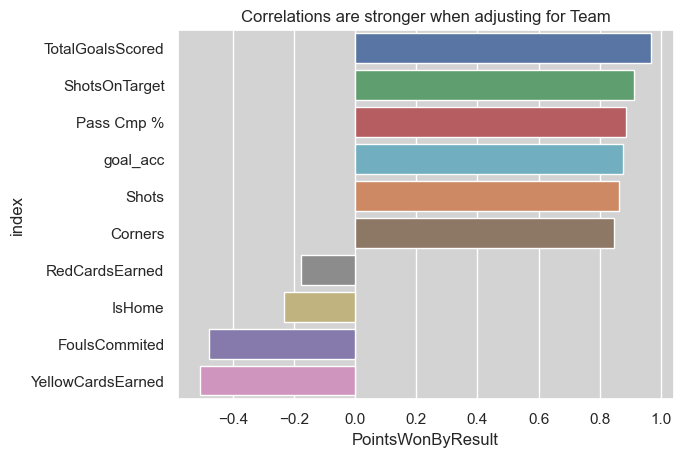

In [206]:
metrics_by_team = metrics.groupby('Team').mean() # Recalculate so that we have result points
correlation_to_PWBR = metrics_by_team.corr()[['PointsWonByResult']].drop('PointsWonByResult').reset_index()
correl = sns.barplot(data=correlation_to_PWBR.sort_values('PointsWonByResult', ascending=False),
                   y='index', x='PointsWonByResult', palette=PWBR_palette)
correl.set(title = 'Correlations are stronger when adjusting for Team');

This had the same effect as we saw earlier: all the weaker correlations became stronger, now that the overrepresentation of those higher-performing teams are accounted for. Grouping by team, we can see that pass completion and corners actually have a much stronger influence on the result of a match than before.

*Remember, IsHome's negative correlation can safely be ignored here. See above for an explanation.*

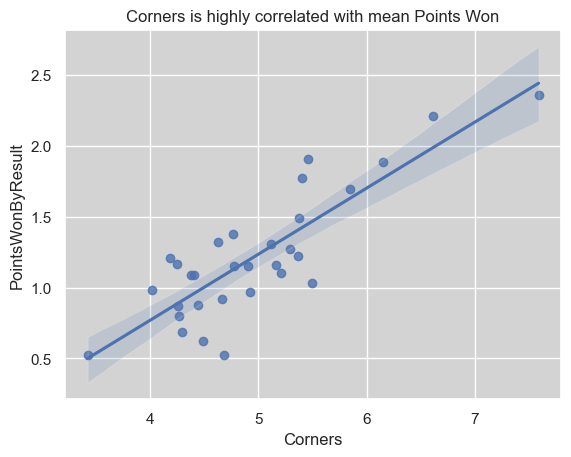

In [230]:
# Sanity Check
fig = sns.regplot(data=metrics_by_team, x='Corners', y='PointsWonByResult')
fig.set(title='Corners is highly correlated with mean Points Won');

### EDA Summary Thus Far:
We have analyzed relationships between all of our in-game variables (fouls, shots, goals cards, etc..) as well as how some of those metrics change alongside the managerial coming and goings of a couple clubs. We have also started to come up with a way to determine which metrics are the biggest contributing factors to wins (and more specifically, points gained). Then, averaging our metrics across teams as a whole, we were able to spot some generalized trends between goals, shots, fouls, etc.. and the points that were won by the result. 

Our final objective now lies in correlating our set of managerial changes with the metrics we have averaged on a team-basis. Plotting those relationships will give us our final insight into what the relationship between a team's managerial changes and their short-terms success after said change. 